In [30]:
import os

import sys
print(sys.version)

import glob
import h5py
import cv2
import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Input, Flatten, Lambda, Reshape, Cropping2D
from keras.models import Model
from keras.datasets import mnist
import numpy as np
from keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.models import Model
import scipy.stats as stats
import PIL
from PIL import Image

import dask
import dask.array as da
from dask.distributed import Client
from dask_image.imread import imread


3.10.16 (main, Dec 11 2024, 16:24:50) [GCC 11.2.0]


In [31]:
# Increase the maximum image pixels limit
PIL.Image.MAX_IMAGE_PIXELS = None

# batch = 200
batch = 2

# train_dir = 'train_folder'
# test_dir = 'test_folder'

# train_dir = 'train_patches'
# test_dir = 'test_patches'

train_dir = 'train_patches_small'
test_dir = 'test_patches_small'

train_samples = len(glob.glob(os.path.join(train_dir, '**', '*.jpg'), recursive=True))
test_samples = len(glob.glob(os.path.join(test_dir, '**', '*.jpg'), recursive=True))

print(f"Training samples: {train_samples}")
print(f"Testing samples: {test_samples}")

# img_height, img_width = 15216, 21397 # Resize to smaller dimensions
# img_height, img_width = 512, 512 # Resize to smaller dimensions
# img_height, img_width = 32, 64 # Resize to smaller dimensions
# img_height, img_width = 3044, 4280 # Resize to smaller dimensions
# img_height, img_width = 1522, 2140 # Resize to smaller dimensions

img_height, img_width = 1024, 1024 # Keep original size of patches

num_channels = 3 # RGB

datagen = ImageDataGenerator(rescale=1./255)

# Load training set in batches
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    color_mode='rgb',
    batch_size=batch,
    class_mode=None,
    shuffle=True,
    seed=42)

# Load test set in batches
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    color_mode='rgb',
    batch_size=batch,
    class_mode=None,
    shuffle=True,
    seed=42)

# Example of loading a batch
x_train_small = next(train_generator)
x_test_small = next(test_generator)

print("Train batch shape:", x_train_small.shape)
print("Test batch shape:", x_test_small.shape)

img_shape = (img_height, img_width, num_channels)

Training samples: 1372
Testing samples: 588
Found 1372 images belonging to 1 classes.
Found 588 images belonging to 1 classes.
Train batch shape: (2, 1024, 1024, 3)
Test batch shape: (2, 1024, 1024, 3)


In [32]:
# anomaly_dir = 'anomaly_folder'

# anomaly_dir = 'anomaly_patches'

anomaly_dir = 'anomaly_patches_small'

anomaly_samples = len(glob.glob(os.path.join(anomaly_dir, '**', '*.jpg'), recursive=True))
print(f"Anomaly samples: {anomaly_samples}")

anomaly_generator = datagen.flow_from_directory(
    anomaly_dir,
    target_size=(img_height, img_width),
    color_mode='rgb',
    # batch_size=99999,
    # batch_size=batch,
    batch_size=10,
    class_mode=None,
    shuffle=True,
    seed=42)

anomaly_data = next(anomaly_generator)
anomaly_test_data = anomaly_data.copy()

Anomaly samples: 1090
Found 1090 images belonging to 1 classes.


In [33]:
print(type(x_train_small))
print(type(anomaly_data))
print(len(x_train_small))
print(len(x_test_small))
print(len(anomaly_data))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
2
2
10


x_train_small shape: (2, 1024, 1024, 3)
train_samples: 1372
[0, 0, 0, 0, 0, 0, 1, 1, 1, 1]

Few of the training data samples are:


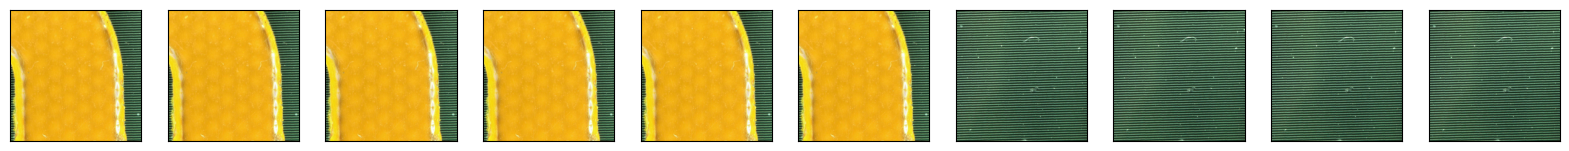

In [34]:
print("x_train_small shape:", x_train_small.shape)
print("train_samples:", train_samples)

n = []
a = 0
for j in range(0, 10):
    n.append(random.randint(0, len(x_train_small) - 1))  # Use -1 to avoid index out of range
print(n)

print('\nFew of the training data samples are:')
plt.figure(figsize=(20, 4))
for i in n:
    a = a + 1
    ax = plt.subplot(2, 10, a)
    plt.imshow(x_train_small[i])  # No reshape needed for RGB images
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


[3, 5, 3, 9, 3, 9, 6, 8, 0, 3]

Few of the Anomaly data samples are:


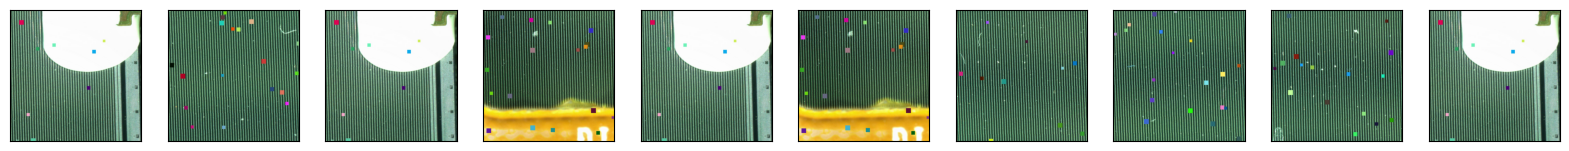

In [35]:
f = []
b = 0
for j in range(0, 10):
    f.append(random.randint(0, len(anomaly_data)-1))
print(f)

print('\nFew of the Anomaly data samples are:')
plt.figure(figsize=(20, 4))
             
for i in f:
    b = b + 1
    ax = plt.subplot(2, 10, b)
    plt.imshow(anomaly_data[i])  # No reshape needed for RGB images
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [36]:
input_img = keras.Input(shape = img_shape)

# x = keras.layers.Conv2D(10, (3, 3), activation='relu', padding='same')(input_img)
# x = keras.layers.MaxPooling2D((2, 2), padding='same')(x)
# x = keras.layers.Conv2D(10, (3, 3), activation='relu', padding='same')(x)
# x = keras.layers.MaxPooling2D((2, 2), padding='same')(x)
# x = keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
# encoded = keras.layers.MaxPooling2D((2, 2), padding='same')(x)

# # x = keras.layers.Conv2D(10, (3, 3), activation='relu', padding='same')(encoded)
# # x = keras.layers.UpSampling2D((2, 2))(x)
# # x = keras.layers.Conv2D(10, (3, 3), activation='relu', padding='same')(x)
# # x = keras.layers.UpSampling2D((2, 2))(x)
# # x = keras.layers.Conv2D(16, (3, 3), activation='relu')(x)
# # x = keras.layers.UpSampling2D((2, 2))(x)
# # decoded = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)


# x = keras.layers.Conv2D(10, (3, 3), activation='relu', padding='same')(encoded)
# x = keras.layers.UpSampling2D((2, 2))(x)
# x = keras.layers.Conv2D(10, (3, 3), activation='relu', padding='same')(x)
# x = keras.layers.UpSampling2D((2, 2))(x)
# x = keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
# x = keras.layers.UpSampling2D((2, 2))(x)
# decoded = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
# # x = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
# # decoded = Cropping2D(((0,6), (0,4)))(x)  # Trim 6 rows and 4 columns




x = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)  # Increased from 10 to 32
x = keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)  # Increased from 10 to 64
x = keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)  # Increased from 8 to 128
encoded = keras.layers.MaxPooling2D((2, 2), padding='same')(x)

x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)  # Increased from 10 to 128
x = keras.layers.UpSampling2D((2, 2))(x)
x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)  # Increased from 10 to 64
x = keras.layers.UpSampling2D((2, 2))(x)
x = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)  # Increased from 16 to 32
x = keras.layers.UpSampling2D((2, 2))(x)
decoded = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)  # Output remains the same


autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

# Evaluation model where output is the loss
loss_layer = Lambda(lambda x: K.mean(K.square(x[0] - x[1])), name='loss_layer', output_shape=lambda s: s[0])
# Define the model
model_evalloss = Model(inputs=[input_img, input_img], outputs=loss_layer([input_img, decoded]))
# model_evalloss.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model_evalloss.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 1024, 1024, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 1024, 1024, 32) │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 512, 512, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 512, 512, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 256, 256, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_6 (UpSampling2D)  │ (None, 256, 256, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 256, 256, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_7 (UpSampling2D)  │ (None, 512, 512, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 512, 512, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_8 (UpSampling2D)  │ (None, 1024, 1024, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 1024, 1024, 3)  │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 333,955 (1.27 MB)

 Trainable params: 333,955 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 1024,      │          0 │ -                 │
│ (InputLayer)        │ 1024, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 1024,      │        896 │ input_layer_2[0]… │
│                     │ 1024, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 512, 512,  │          0 │ conv2d_14[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 512, 512,  │     18,496 │ max_pooling2d_6[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 256, 256,  │          0 │ conv2d_15[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 256, 256,  │     73,856 │ max_pooling2d_7[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 128, 128,  │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 128, 128,  │    147,584 │ max_pooling2d_8[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_6     │ (None, 256, 256,  │          0 │ conv2d_17[0][0]   │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 256, 256,  │     73,792 │ up_sampling2d_6[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_7     │ (None, 512, 512,  │          0 │ conv2d_18[0][0]   │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 512, 512,  │     18,464 │ up_sampling2d_7[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_8     │ (None, 1024,      │          0 │ conv2d_19[0][0]   │
│ (UpSampling2D)      │ 1024, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 1024,      │        867 │ up_sampling2d_8[… │
│                     │ 1024, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ loss_layer (Lambda) │ (None, 1024,      │          0 │ input_layer_2[0]… │
│                     │ 1024, 3)          │            │ conv2d_20[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 333,955 (1.27 MB)

 Trainable params: 333,955 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# x_train_small = x_train_small.astype('float16')/255.0
# x_test_small = x_test_small.astype('float16')/255.0

# # Example: Resize each image in the dataset to 128x128
# x_train_small_resized = np.array([np.array(Image.open(img).resize((128, 128))) for img in x_train_small])
# x_test_small_resized = np.array([np.array(Image.open(img).resize((128, 128))) for img in x_test_small])


# print(f"Training data size (GB): {x_train_small.nbytes / (1024**3):.2f} GB")
# print("Shape:", x_train_small.shape)

# print(f"Testing data size (GB): {x_test_small.nbytes / (1024**3):.2f} GB")
# print("Shape:", x_test_small.shape)

# print(tf.config.list_physical_devices('GPU'))

# gpu_devices = tf.config.list_physical_devices('GPU')  # Non-experimental method
# for device in gpu_devices:
#     print(tf.config.experimental.get_memory_info("GPU:0"))  # Use "GPU:0" directly


def data_generator(x_data, batch_size):
    while True:  # For infinite training
        for i in range(0, len(x_data), batch_size):
            x_batch = x_data[i:i+batch_size]
            yield x_batch, x_batch  # for autoencoder: input = target

# batch = 1  # or 2, depending on memory
train_gen = tf.data.Dataset.from_generator(
    lambda: data_generator(x_train_small, batch),
    output_signature=(
        tf.TensorSpec(shape=(None, img_height, img_width, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, img_height, img_width, 3), dtype=tf.float32),
    )
)

val_gen = tf.data.Dataset.from_generator(
    lambda: data_generator(x_test_small, batch),
    output_signature=(
        tf.TensorSpec(shape=(None, img_height, img_width, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, img_height, img_width, 3), dtype=tf.float32),
    )
)

a = autoencoder.fit(
    train_gen,
    # epochs=25,
    epochs=500,
    steps_per_epoch=len(x_train_small) // batch,
    validation_data=val_gen,
    validation_steps=len(x_test_small) // batch,
    # callbacks=[GPUMemoryCallback()]
)

Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0951 - val_loss: 0.0560
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 905ms/step - loss: 0.0842 - val_loss: 0.0507
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 906ms/step - loss: 0.0649 - val_loss: 0.0503
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933ms/step - loss: 0.0445 - val_loss: 0.0476
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933ms/step - loss: 0.0378 - val_loss: 0.0486
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 908ms/step - loss: 0.0344 - val_loss: 0.0496
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/step - loss: 0.0311 - val_loss: 0.0432
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 912ms/step - loss: 0.0277 - val_loss: 0.0366
Epoch 9/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 877ms/step - loss: 0.0247 - val_loss: 0.0350
Epoch 10/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 928ms/step - loss: 0.0248 - val_loss: 0.0350
Epoch 11/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 932ms/step - loss: 0.0256 - val_loss: 0.0342
Epoch 12/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 888ms/step - loss: 0.0251

In [38]:
results = autoencoder.evaluate(x_test_small, x_test_small, verbose=0)
print ("Test MSE loss:", results)

results_anom = autoencoder.evaluate(anomaly_data, anomaly_data, verbose=0)
print ("Anomaly MSE loss:", results_anom)




Test MSE loss: 0.00432534608989954
Anomaly MSE loss: 0.014875665307044983


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


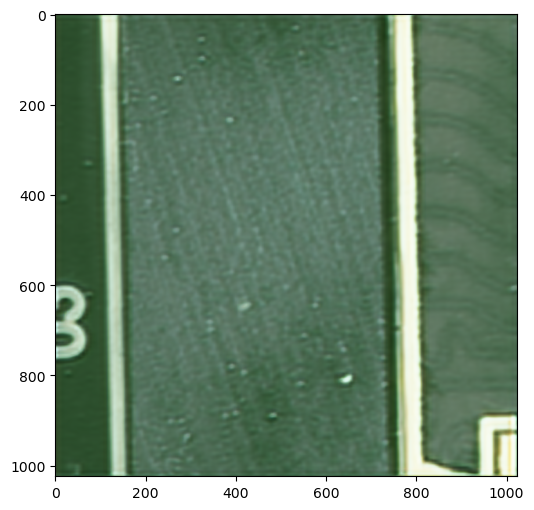

In [39]:
#Draw a test image
im_test = autoencoder.predict(x_test_small[:1])
plt.imshow(im_test[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


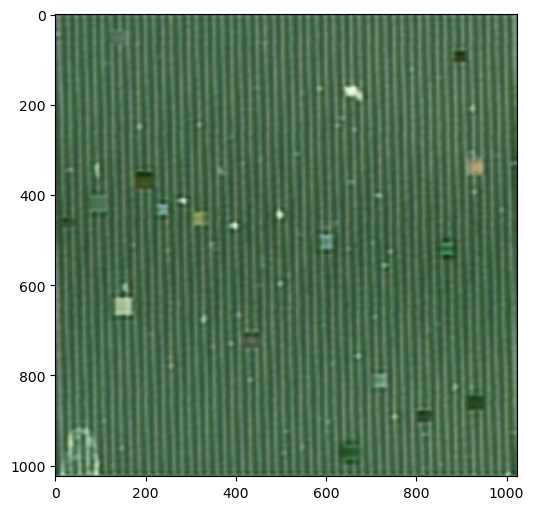

In [40]:
# Draw an anomaly image
im = autoencoder.predict(anomaly_data[:1])
plt.imshow(im[0])

In [41]:
decoded_imgs = autoencoder.predict(x_test_small)
decoded_imgs_anom = autoencoder.predict(anomaly_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 887ms/step


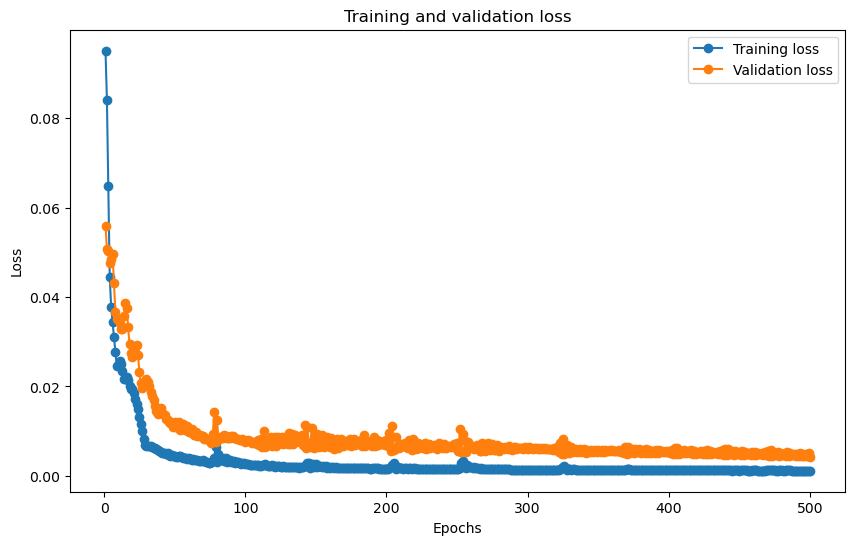

In [42]:
plt.rcParams["figure.figsize"] = (10,6)
loss = a.history['loss']
val_loss = a.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, '-o', label='Training loss')
plt.plot(epochs, val_loss, '-o', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The orignal images are:


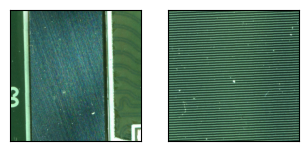


The reconstructed images are:


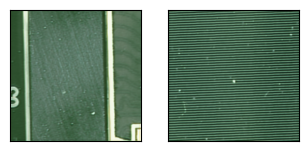

In [43]:
n = 10
plt.figure(figsize=(20, 4))
print("The orignal images are:")
for i in range(0, min(n, len(x_test_small))):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_small[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

print("\nThe reconstructed images are:")
plt.figure(figsize=(20, 4))
for i in range(0, min(n, len(decoded_imgs))):
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


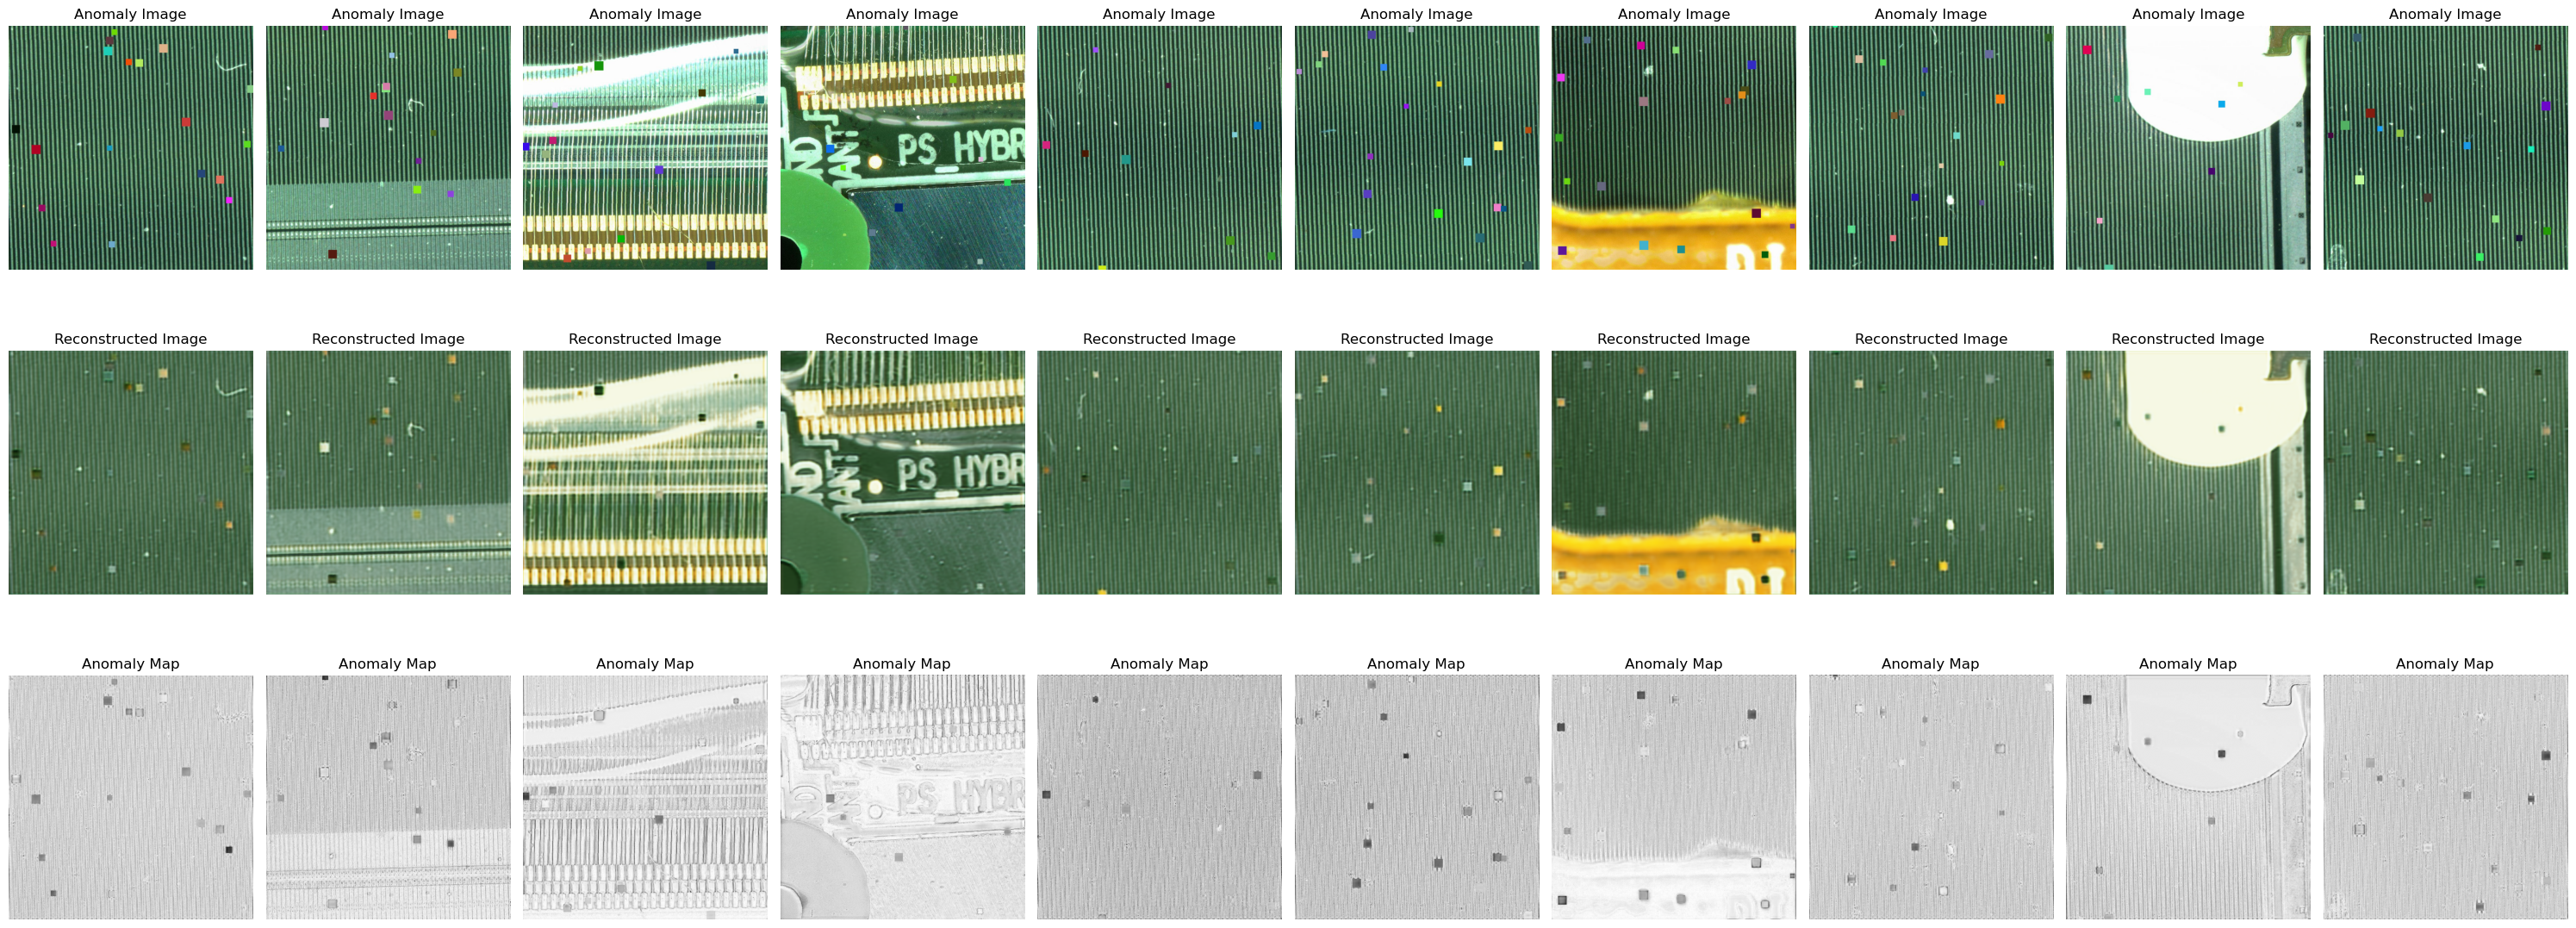

In [ ]:
# Select 10 random indices from anomaly_data
num_samples = min(10, len(anomaly_data))
random_indices = random.sample(range(len(anomaly_data)), num_samples)

plt.figure(figsize=(30, 12))
for idx, i in enumerate(random_indices):
    # Original anomaly image
    original = anomaly_data[i]
    # Reconstructed image
    reconstructed = autoencoder.predict(original[np.newaxis, ...])[0]
    # Compute anomaly map (absolute difference)
    anomaly_map = np.abs(original - reconstructed)
    # Optionally, sum across channels for visualization
    anomaly_map_gray = np.mean(anomaly_map, axis=-1)
    
    # Plot original
    ax1 = plt.subplot(3, num_samples, idx + 1)
    plt.imshow(original)
    ax1.set_title("Anomaly Image")
    ax1.axis('off')

    # Plot reconstructed
    ax2 = plt.subplot(3, num_samples, idx + num_samples + 1)
    plt.imshow(reconstructed)
    ax2.set_title("Reconstructed Image")
    ax2.axis('off')
    
    # Plot anomaly map
    ax3 = plt.subplot(3, num_samples, idx + 2*num_samples + 1)
    # plt.imshow(anomaly_map_gray, cmap='hot')
    plt.imshow(anomaly_map_gray, cmap='binary')
    ax3.set_title("Anomaly Map")
    ax3.axis('off')

plt.tight_layout()
plt.show()